Over the past week I have primarily worked on trying to get Bayesian Sindy to work on the predator prey data for a complete. library $[u,v,u^2,v^2,uv]$. In the past, our library has been only a subset of these terms. For this past week, I have focused on a synthetic system (see data below). The xi values are not perfect. However, the pnss values are good and overall, this seems to work. Going forward there are a few areas which I plan to look into: 

1. Using the same prior for all terms in Sindy library. Currently a couple of the linear terms in the model have priors which have a variance larger than the rest. This is necessary since the true values of these parameters are larger in magnitude. Perhaps we can scale the data so that all parameters are on the same scale?
2. Use real data (or at least a more sparsely sampled dataset).

Other things we can look into going forward
3. Speedup runtime - Current runtime using NUTS is approximately 4hrs. Using Metropolis is much faster at sampling and computing an accurate trace but is super slow when saving data and plotting. Perhaps variational methods may help?
4. Incorporate regularized horseshoe prior. 


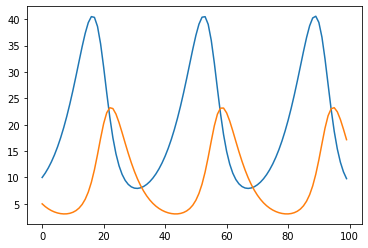

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 15,  100)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

yobs = X.T #* np.random.lognormal(mean=-1,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = t

plt.figure()
plt.plot(yobs)
plt.show()



In [2]:
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn00 * y.u + p.pn0 * y.u * y.u + p.pn2 * y.u * y.v + p.pn4 * y.v + p.pn6* y.v**2 - 1e-5 * y.u**3
    dv_dt = p.pn11 * y.v + p.pn1 * y.v * y.v + p.pn3 * y.u * y.v + p.pn5 * y.u + p.pn7*y.u**2 - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}



model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    #sigma = pm.Lognormal('sigma', mu=0., sigma=1.0, shape=2)
    p0 = pm.Normal('p0', mu=0, sigma=1.0)
    p1 = pm.Normal('p1', mu=0, sigma=1.0)

    #pn = pm.Normal('pn', mu=0, sigma=0.1, shape=4)
    pn = pm.Laplace('pn', mu=0, b=0.1, shape=8)

   # r  = pm.Beta('r', 1, beta)
   # xi = pm.Bernoulli('xi', r, shape=4)

    xi = pm.Bernoulli('xi', 0.8, shape=8)

    xip0 = pm.Bernoulli('xip0', 0.8)
    xip1 = pm.Bernoulli('xip1', 0.8)
    pn0 = pm.Deterministic('pn0',p0 * xip0)
    pn1 = pm.Deterministic('pn1',p1 * xip1)

    pnss = pm.Deterministic('pnss', pn * xi)

    y0 = pm.Lognormal('y0', mu=pm.math.log(10), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn00': (pn0, ()),
                'pn11': (pn1, ()),
                'pn0': (pnss[0], ()),
                'pn1': (pnss[1], ()),
                'pn2': (pnss[2], ()),
                'pn3': (pnss[3], ()),
                'pn4': (pnss[4], ()),
                'pn5': (pnss[5], ()),
                'pn6': (pnss[6], ()),
                'pn7': (pnss[7], ()),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs[:,1])



<Figure size 432x288 with 0 Axes>

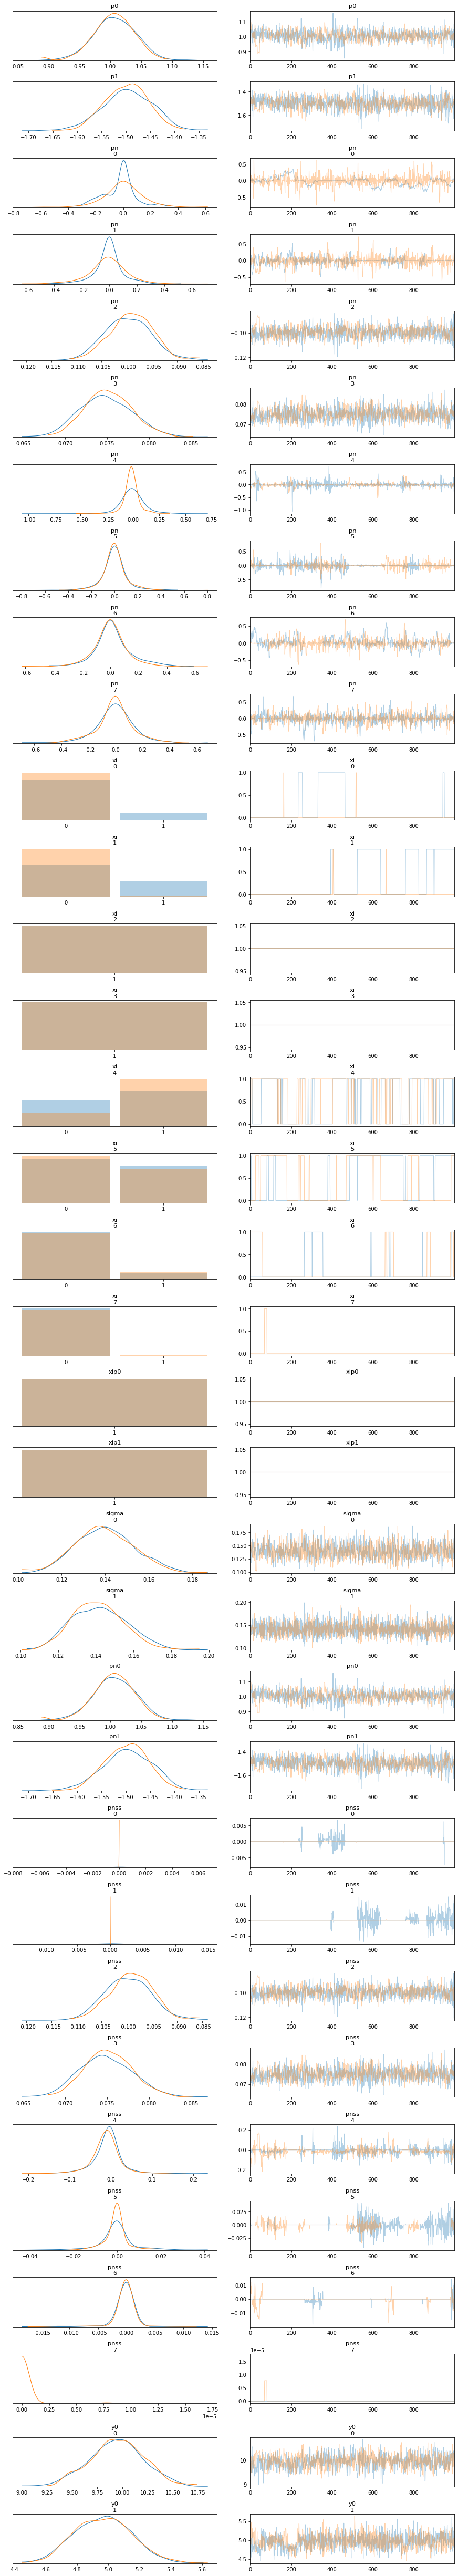

In [3]:
trace= pm.load_trace('synthetic_reg_minus_5_full_sindy_10.trace',model_sunode)
plt.figure()
pm.traceplot(trace,compact=False)
plt.show()    


In [4]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p0,1.006,0.034,0.947,1.070,0.001,0.001,509.0,509.0,556.0,357.0,1.00
p1,-1.498,0.048,-1.584,-1.412,0.002,0.001,950.0,937.0,960.0,1327.0,1.01
pn[0],-0.011,0.137,-0.258,0.278,0.016,0.011,73.0,73.0,70.0,105.0,1.06
pn[1],-0.008,0.125,-0.264,0.239,0.006,0.005,501.0,317.0,644.0,323.0,1.17
pn[2],-0.099,0.005,-0.108,-0.091,0.000,0.000,561.0,561.0,577.0,530.0,1.00
pn[3],0.075,0.003,0.069,0.080,0.000,0.000,852.0,849.0,851.0,957.0,1.01
pn[4],-0.010,0.096,-0.169,0.169,0.003,0.004,1107.0,355.0,1198.0,411.0,1.02
pn[5],-0.000,0.105,-0.202,0.230,0.003,0.004,1468.0,297.0,1988.0,528.0,1.08
pn[6],0.012,0.131,-0.239,0.301,0.007,0.006,334.0,265.0,375.0,290.0,1.01
pn[7],-0.005,0.150,-0.339,0.274,0.006,0.005,570.0,475.0,678.0,544.0,1.00
